# Train a deep, recurrent convolutional SNN on the SHD dataset

In this notebook, we demonstrate the training of a 3-layer convolutional SNN with recurrent connections in each hidden layer on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the use of the `layer` module to initialize feed-forward and recurrent connections at the same time, from the same target parameter $\sigma_U$.

In [25]:
# First, imports
import os
import sys
sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

import stork

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConvConnection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer, DistInitializer, KaimingNormalInitializer
from stork.layers import ConvLayer

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

#### Specifying dataset parameters

In [3]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None
    )

#### Load and split dataset into train / validation / test

In [4]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [5]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 1
nb_classes = 20
nb_filters = [16]      # Number of features per layer

kernel_size = [21]        # Convolutional operation parameters
stride = [10]
padding = [0]

recurrent_kwargs = {'kernel_size': 5,
                    'stride': 1,
                    'padding': 2}

# Neuron Parameters
# # # # # # # # # # #

neuron_group = DeltaSynapseLIFGroup
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

# FILTER PARAMETERS
# # # # # # # # # # #
nb_synaptic_filters = 10
tau_filter = 20e-3

# Training parameters
# # # # # # # # # # #

batch_size = 400
device = torch.device("cuda:0")
dtype = torch.float
lr = 5e-3
nb_epochs = 200

#### SuperSpike and loss function setup

In [6]:

act_fn = stork.activations.SuperSpike
act_fn.beta = beta

loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

#### Optimizer setup

In [7]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

#### Regularizer setup

In [8]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.01
upperBoundL2Threshold = 7       # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time

# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,
                                        threshold=upperBoundL2Threshold, 
                                        dims=-1)
regs.append(regUB)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [9]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt,
    alpha=0.9
    )

readout_initializer = DistInitializer(
    dist = torch.distributions.Normal(0, 1),
    scaling='1/sqrt(k)'
)

super_initializer = KaimingNormalInitializer(gain=2)

#### Assemble the model

In [10]:
model = RecurrentSpikingModel(
    batch_size,
    nb_time_steps,
    nb_inputs,
    device,
    dtype)

# INPUT LAYER
# # # # # # # # # # # # # # #
input_shape = (1, nb_inputs)
input_group = model.add_group(InputGroup(input_shape))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYERS
# # # # # # # # # # # # # # #
neuron_kwargs = {'tau_mem': 20e-3,
                 'activation': act_fn}

for layer_idx in range(nb_hidden_layers):
    
    # Generate Layer name and config
    layer_name = str('ConvLayer') + ' ' + str(layer_idx)

    # Make layer
    layer = ConvLayer(name = layer_name, 
                      model = model,
                      input_group = upstream_group,
                      kernel_size = kernel_size[layer_idx],
                      stride = stride[layer_idx],
                      padding = padding[layer_idx],
                      nb_filters= nb_filters[layer_idx],
                      recurrent = False,
                      neuron_class = neuron_group,
                      neuron_kwargs = neuron_kwargs,
                      connection_class=SuperConvConnection,
                      connection_kwargs={'tau_filter': tau_filter,
                                         'nb_filters': nb_synaptic_filters,},
                      recurrent_connection_kwargs = recurrent_kwargs,
                      regs = regs,
                      )
    
    # Initialize Parameters
    super_initializer.initialize(layer)
    
    # Set output as input to next layer
    upstream_group = layer.output_group

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=tau_syn,
    initial_state=-1e-3))

readout_connection = model.add_connection(Connection(upstream_group, 
                                                     readout_group,
                                                     flatten_input=True))

# Initialize readout connection
readout_initializer.initialize(readout_connection)



#### Add monitors for spikes and membrane potential

In [11]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

#### Configure model for training

In [12]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

## Monitoring activity before training

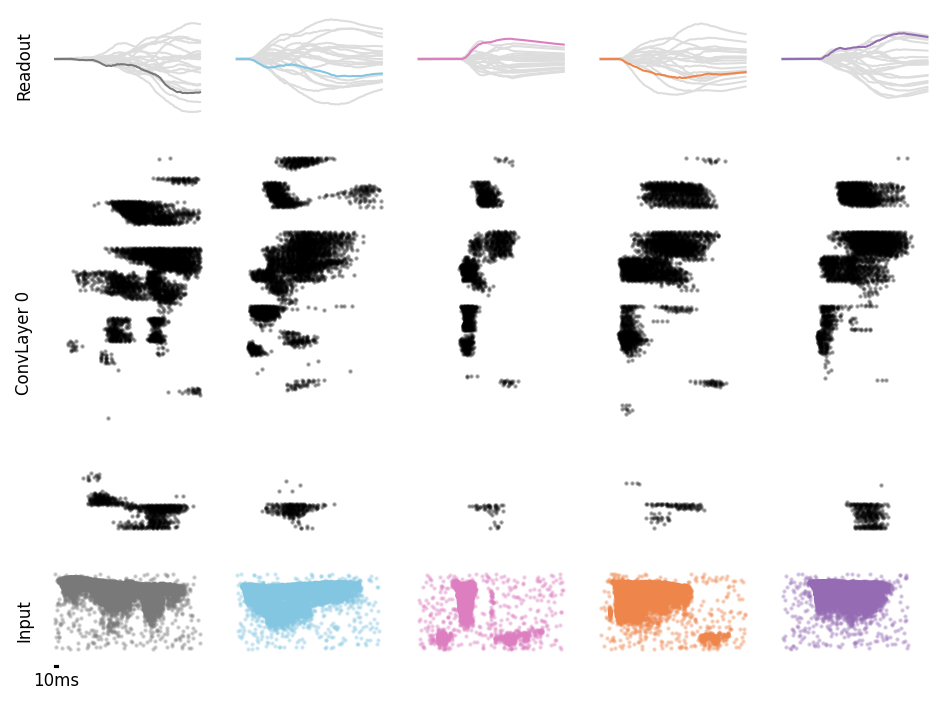

In [13]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

In [14]:
before_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(before_weighted_filters.shape)

# Sum over filter axis
before_weighted_filters_sum = before_weighted_filters.sum(axis=3)

(350, 16, 1, 10, 21)


## Training

takes around 85 minutes using a powerful GPU

In [15]:
results = {}

history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=2.84 reg_loss=0.0186 acc=0.156 -- val_loss=2.6 val_reg_loss=0.0341 val_acc=0.226 t_iter=12.72
01  loss=2.27 reg_loss=0.0529 acc=0.322 -- val_loss=1.96 val_reg_loss=0.0962 val_acc=0.453 t_iter=12.81
02  loss=1.7 reg_loss=0.0895 acc=0.485 -- val_loss=1.51 val_reg_loss=0.0896 val_acc=0.53 t_iter=12.67
03  loss=1.32 reg_loss=0.0998 acc=0.619 -- val_loss=1.26 val_reg_loss=0.103 val_acc=0.622 t_iter=12.43
04  loss=1.14 reg_loss=0.109 acc=0.663 -- val_loss=1.19 val_reg_loss=0.103 val_acc=0.629 t_iter=12.46
05  loss=0.99 reg_loss=0.107 acc=0.714 -- val_loss=0.967 val_reg_loss=0.104 val_acc=0.747 t_iter=12.59
06  loss=0.867 reg_loss=0.112 acc=0.755 -- val_loss=0.853 val_reg_loss=0.101 val_acc=0.791 t_iter=12.98
07  loss=0.791 reg_loss=0.11 acc=0.776 -- val_loss=0.821 val_reg_loss=0.103 val_acc=0.763 t_iter=12.86
08  loss=0.724 reg_loss=0.108 acc=0.796 -- val_loss=0.712 val_reg_loss=0.0987 val_acc=0.809 t_iter=12.64
09  loss=0.643 reg_loss=0.106 acc=0.831 -- val_loss=0.674 val_reg_loss=

KeyboardInterrupt: 

## Test

In [16]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

#### Visualize performance

KeyError: 'train_loss'

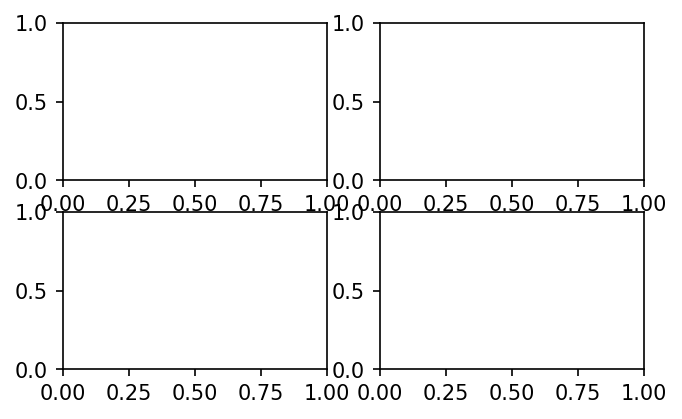

In [17]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

print("\nValidation loss: ", results["valid_loss"][-1])
print("Validation acc.: ", results["valid_acc"][-1])

#### Snapshot after training

In [18]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.73 GiB of which 36.69 MiB is free. Including non-PyTorch memory, this process has 14.79 GiB memory in use. Of the allocated memory 14.28 GiB is allocated by PyTorch, and 357.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 960x720 with 0 Axes>

In [24]:
after_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(after_weighted_filters.shape)

# Sum over filter axis
after_weighted_filters_sum = after_weighted_filters.sum(axis=3)

print(after_weighted_filters_sum.shape)

(350, 16, 1, 10, 21)
(350, 16, 1, 21)


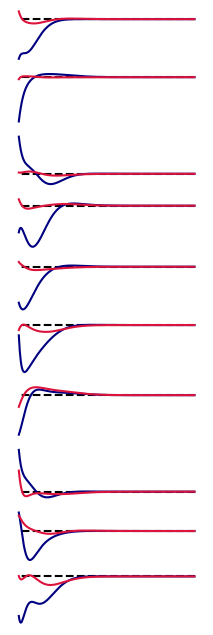

In [27]:
fig = MultiPanel(grid=[1] * 10, figsize=(2.5, 8), dpi=150)

for idx in range(10):
    fig.panels[idx].hlines(0, after_weighted_filters_sum.shape[0], 0, color="black", linestyle="--")
    fig.panels[idx].plot(after_weighted_filters_sum[:, idx, 0, 0], color='navy')
    fig.panels[idx].plot(before_weighted_filters_sum[:, idx, 0, 0], color='crimson')

    fig.panels[idx].axis('off')